# Importing important libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
import json

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [ ]:
iphone_tweets = pd.read_csv("iphone_14_pre_release.csv")
print("Dataframe shape:", iphone_tweets.shape)
iphone_tweets.head()

Dataframe shape: (4999, 29)


,Unnamed: 0,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,...,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/C18599370Chavez/status/157...,2022-09-21 23:59:56+00:00,iPHONE 14 vs iPHONE 13 - ¿Cambia Algo? https:/...,iPHONE 14 vs iPHONE 13 - ¿Cambia Algo? youtu.b...,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,{'_type': 'snscrape.modules.twitter.PlayerCard...
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/jil_dvn_english/status/157...,2022-09-21 23:59:20+00:00,The iPhone 14 Pro Is Finally What You Want An ...,The iPhone 14 Pro Is Finally What You Want An ...,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'_type': 'snscrape.modules.twitter.SummaryCar...
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/treydeantai/status/1572737...,2022-09-21 23:59:09+00:00,My iPhone 14 Pro Max case is 💜,My iPhone 14 Pro Max case is 💜,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,"{'_type': 'snscrape.modules.twitter.Tweet', 'u...",NaN,NaN,NaN,{'_type': 'snscrape.modules.twitter.Coordinate...,"{'_type': 'snscrape.modules.twitter.Place', 'f...",NaN,NaN,NaN
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/arstechnica/status/1572737...,2022-09-21 23:59:05+00:00,"Whether we’re talking about the 14, bad the 14...","Whether we’re talking about the 14, the 14 Pro...",1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'_type': 'snscrape.modules.twitter.SummaryCar...
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/iluvoddy/status/1572737089...,2022-09-21 23:58:36+00:00,im sorry but theres nothing the new iphone 14 ...,im sorry but theres nothing the new iphone 14 ...,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Handling Missing Values

In [ ]:
iphone_tweets.isna().sum()

Unnamed: 0             0
_type                  0
url                    0
date                   0
rawContent             0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
links               2786
media               4168
retweetedTweet      4999
quotedTweet         4879
inReplyToTweetId    3915
inReplyToUser       3915
mentionedUsers      3676
coordinates         4885
place               4885
hashtags            4043
cashtags            4982
card                3366
dtype: int64

In [ ]:
iphone_tweets.columns[iphone_tweets.isnull().any()]

Index(['links', 'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
       'inReplyToUser', 'mentionedUsers', 'coordinates', 'place', 'hashtags',
       'cashtags', 'card'],
      dtype='object')

Since, all of these columns are not that useful in our sentimental analysis or data exploration, we can safely ignore these null values, except the column place and coordinates, which we plan to explore after our sentimental analysis. Thus, to treat these two columns: 

In [ ]:
country_list = ['Not recorded']*len(iphone_tweets)

Initializing country names as not recorded, this way we can fetch the country name, and handle null values in that column

In [ ]:
for index in range(0, len(iphone_tweets)):
  country_data = iphone_tweets['place'][index]
  if(iphone_tweets['place'][index] is not np.nan):
    country_json_object = json.loads(iphone_tweets['place'][index].replace("'", '"'))
    country_list[index] = country_json_object['country']

In [ ]:
#json_object = json.loads(iphone_tweets['place'][1].replace("'", '"'))

In [ ]:
iphone_tweets['country'] = country_list

In [ ]:
iphone_tweets['country'].unique()

array(['Not recorded', 'United States', 'Japan', 'Dominican Republic',
       'Portugal', 'Colombia', 'Brazil', 'Argentina',
       'Republic of the Philippines', 'United Kingdom', 'Turkey',
       'Democratic Republic of Congo', 'Cuba', 'France', 'Pakistan',
       'Nigeria', 'Australia', 'Malawi', 'Kingdom of Saudi Arabia',
       'Canada', 'Austria', 'India', 'Costa Rica', 'Honduras', 'Sweden',
       'Cape Verde', 'Morocco', 'Malta', 'Trinidad and Tobago', 'Mali',
       'Spain', 'United Arab Emirates', 'Venezuela', 'The Netherlands',
       'Sri Lanka', 'Azerbaijan', 'Uganda', 'Malaysia'], dtype=object)

In [ ]:
iphone_tweets.isnull().sum()

Unnamed: 0             0
_type                  0
url                    0
date                   0
rawContent             0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
links               2786
media               4168
retweetedTweet      4999
quotedTweet         4879
inReplyToTweetId    3915
inReplyToUser       3915
mentionedUsers      3676
coordinates         4885
place               4885
hashtags            4043
cashtags            4982
card                3366
country                0
dtype: int64

# EDA

Let us explore importance of the tweets: </br>
To do so we're taking *likeCount* column, which signifies that more number of like on a tweet means more important the tweet is to us.

In [ ]:
import plotly.express as px

In [ ]:
iphone_tweets['likeCount']

0        1
1        0
2        1
3        2
4        2
        ..
4994    34
4995     0
4996     0
4997     0
4998     0
Name: likeCount, Length: 4999, dtype: int64

In [ ]:
max(iphone_tweets['likeCount'])

68953

In [ ]:
min(iphone_tweets['likeCount'])

0

Since, the max value in our tweet list count list is 27206 means that we might extract a few tweets that are relevant and will support our final aim of this project.

In [ ]:
iphone_tweets['likeCount'].mean()

26.35467093418684

Although, we have higher importance since our mean of the like counts is less signifies that the count is skewed towards less number of likes. To show this we plot a histogram plot.

In [ ]:
df = px.data.tips()
fig = px.histogram(iphone_tweets, x='likeCount')
fig.show()

Looks like we have more number of 0 likes in the tweet which is reason of this skew. Let us try without the 0 values.

In [ ]:
iphone_tweets[iphone_tweets['likeCount']!=0]['likeCount']

0        1
2        1
3        2
4        2
5       34
        ..
4980     2
4986     1
4989    12
4991     1
4994    34
Name: likeCount, Length: 1838, dtype: int64

In [ ]:
df = px.data.tips()
fig = px.histogram(iphone_tweets[iphone_tweets['likeCount']!=0], x='likeCount')
fig.show()

This helps us prove our hypothesis that the data is heavily skewed towards less value. That means the like count is not that valuable to explore. Most of the like counts lie in the range of 0-99.

In [ ]:
idx = np.where((iphone_tweets['likeCount']<99) & (iphone_tweets['likeCount']>0))
temp_df = iphone_tweets.loc[idx]

In [ ]:
df = px.data.tips()
fig = px.histogram(temp_df, x='likeCount')
fig.show()

In [ ]:
fig = px.scatter(temp_df, y='likeCount', size='likeCount', color="country",
                 hover_name="country", log_x=True, size_max=60)
fig.show()

In [ ]:
fig = px.scatter(temp_df[temp_df['country']!='Not recorded'], y='likeCount', size='likeCount', color="country",
                 hover_name="country", log_x=True, size_max=60)
fig.show()

Insights from this graph:


1.  Dominated country is in blue - United States - most tweets are from US.
2.  Most number of highest likes on tweet is from US.
3.  Second domiated colour is red(Spain) and green(Austria).

How is this helpful?</br>
Since for now our data is limited, we cannot fully commit to the hypotheses. But if we in future get hold to a versatile and fully extended data with all the computation tweets that are needed we can easily tell if the tweets are going to help us or not. </br>
As, this data tells us that the most number of tweets are from US - which works in our favour as most number of crtiques, reviewers and smartphone pundits are from US. If we apply the same methodology on a fully extensible data we might receive more promising result.


In [ ]:
'''import plotly.express as px
df = px.data.tips()
fig = px.box(temp_df, y="likeCount", x="country")
fig.show()'''

'import plotly.express as px\ndf = px.data.tips()\nfig = px.box(temp_df, y="likeCount", x="country")\nfig.show()'

Like this feature analysis of likeCount we can estimate the same with others as well, given that we have a sophisticated and fully extensible data which covers the data for all the features pretty well. </br>
</br>
With these things in hand we can furthur extend and perform weighted sentimental analysis given importance to each review or tweet based on the relevance and importance that it deserves.</br>

# Sentimental Analysis for iPhone 14 pre-release

## Vader

In [ ]:
iphone_tweets.isna().sum()

Unnamed: 0             0
_type                  0
url                    0
date                   0
rawContent             0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
links               2786
media               4168
retweetedTweet      4999
quotedTweet         4879
inReplyToTweetId    3915
inReplyToUser       3915
mentionedUsers      3676
coordinates         4885
place               4885
hashtags            4043
cashtags            4982
card                3366
country                0
dtype: int64

In [ ]:
iphone_tweets.dropna(subset=['rawContent'], inplace=True)

In [ ]:
iphone_tweets['rawContent'] = iphone_tweets['rawContent'].apply(lambda txt: txt.lower())

In [ ]:
stop_words=stopwords.words('english')
iphone_tweets['rawContent'] = iphone_tweets['rawContent'].apply(lambda txt: ' '.join([word for word in txt.split() if word not in stop_words]))

In [ ]:
iphone_tweets['rawContent'] = iphone_tweets['rawContent'].apply(lambda txt: sent_tokenize(txt))

In [ ]:
iphone_tweets['rawContent'] = iphone_tweets['rawContent'].apply(lambda txt: ' '.join(txt))

In [ ]:
sid1 = SentimentIntensityAnalyzer()

In [ ]:
iphone_tweets['score'] = iphone_tweets['rawContent'].apply(lambda txt: sid1.polarity_scores(txt))

In [ ]:
iphone_tweets['negative'] = iphone_tweets['score'].apply(lambda txt: txt['neg'])
iphone_tweets['neutral'] = iphone_tweets['score'].apply(lambda txt: txt['neu'])
iphone_tweets['positive'] = iphone_tweets['score'].apply(lambda txt: txt['pos'])
iphone_tweets['compound'] = iphone_tweets['score'].apply(lambda txt: txt['compound'])

In [ ]:
def polarity_score(compound):
    if compound > 0:
        return "positive"
    elif compound < 0:
        return "negative"
    elif compound == 0:
        return "neutral"

In [ ]:
iphone_tweets['sentiment'] = iphone_tweets['compound'].apply(lambda val: polarity_score(val))
iphone_tweets.head()

,Unnamed: 0,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,...,hashtags,cashtags,card,country,score,negative,neutral,positive,compound,sentiment
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/C18599370Chavez/status/157...,2022-09-21 23:59:56+00:00,iphone 14 vs iphone 13 - ¿cambia algo? https:/...,iPHONE 14 vs iPHONE 13 - ¿Cambia Algo? youtu.b...,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,{'_type': 'snscrape.modules.twitter.PlayerCard...,Not recorded,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/jil_dvn_english/status/157...,2022-09-21 23:59:20+00:00,iphone 14 pro finally want iphone https://t.co...,The iPhone 14 Pro Is Finally What You Want An ...,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,{'_type': 'snscrape.modules.twitter.SummaryCar...,Not recorded,"{'neg': 0.293, 'neu': 0.666, 'pos': 0.041, 'co...",0.293,0.666,0.041,-0.8369,negative
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/treydeantai/status/1572737...,2022-09-21 23:59:09+00:00,iphone 14 pro max case 💜,My iPhone 14 Pro Max case is 💜,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,United States,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/arstechnica/status/1572737...,2022-09-21 23:59:05+00:00,"whether we’re talking 14, bad 14 pro, 14 pro m...","Whether we’re talking about the 14, the 14 Pro...",1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,1,...,NaN,NaN,{'_type': 'snscrape.modules.twitter.SummaryCar...,Not recorded,"{'neg': 0.187, 'neu': 0.775, 'pos': 0.037, 'co...",0.187,0.775,0.037,-0.7650,negative
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/iluvoddy/status/1572737089...,2022-09-21 23:58:36+00:00,im sorry theres nothing new iphone 14 beat lil...,im sorry but theres nothing the new iphone 14 ...,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,...,NaN,NaN,NaN,Not recorded,"{'neg': 0.29, 'neu': 0.71, 'pos': 0.0, 'compou...",0.290,0.710,0.000,-0.5994,negative


In [ ]:
iphone_tweets.loc[2]['rawContent']

'iphone 14 pro max case 💜'

In [ ]:
iphone_tweets.loc[293]['rawContent']

'apple 新宿にて iphone 14 bad pro:ゴールド:256gbの店頭在庫を検知しました。 bad 商品ページ:https://t.co/mbr8ajzwea [2022/09/22 08:21:47]'

In [ ]:
iphone_tweets['sentiment']

0        neutral
1       negative
2        neutral
3       negative
4       negative
          ...   
4994     neutral
4995    negative
4996    negative
4997    negative
4998     neutral
Name: sentiment, Length: 4999, dtype: object

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
color_code = {'negative': '#C41E3A', 'positive': '#0094DE', 'neutral':'#61727B'}

In [ ]:
fig = px.histogram(iphone_tweets, x='sentiment', color = 'sentiment', color_discrete_map = color_code)
fig.show()

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
tweets = " ".join(iphone_tweets['rawContent'])

word_cloud = WordCloud(stopwords = ENGLISH_STOP_WORDS,
                       width = 800, 
                       height = 400)

word_cloud.generate(tweets)

(-0.5, 799.5, 399.5, -0.5)

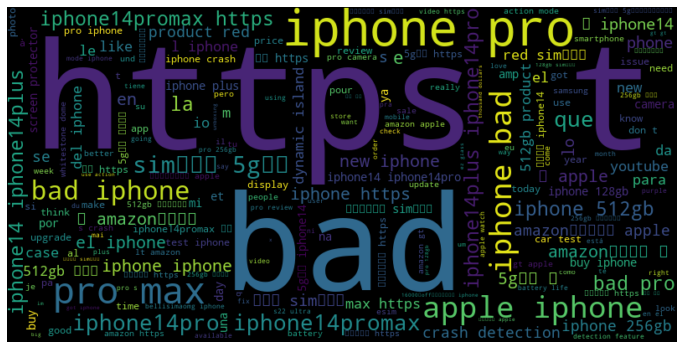

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')

## BERT

In [ ]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
classifier = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
iphone_tweets['rawContent'][963]

'keep telling buy iphone 14, got xr cracked screen n going slow. keep complaining it. anyway?'

In [ ]:
senti_score=[0]*len(iphone_tweets)
for ind in range(0, len(iphone_tweets)):
  senti_score[ind] = classifier(iphone_tweets['rawContent'][ind])[0]['score']

In [ ]:
senti_score

[0.2588058114051819,
 0.3559627830982208,
 0.4357036352157593,
 0.4854303300380707,
 0.6807442307472229,
 0.5573853850364685,
 0.28347113728523254,
 0.508945882320404,
 0.37625595927238464,
 0.2791574001312256,
 0.40120190382003784,
 0.7461856007575989,
 0.43443140387535095,
 0.4450761675834656,
 0.42171499133110046,
 0.40794724225997925,
 0.5482316613197327,
 0.6469256281852722,
 0.3906908333301544,
 0.3769284784793854,
 0.5310096144676208,
 0.28141963481903076,
 0.3467010259628296,
 0.39785605669021606,
 0.6446582674980164,
 0.6193305253982544,
 0.681517481803894,
 0.6646057963371277,
 0.3525307774543762,
 0.7626048922538757,
 0.7321097254753113,
 0.48014259338378906,
 0.4958936870098114,
 0.34619811177253723,
 0.508913516998291,
 0.46992722153663635,
 0.5216604471206665,
 0.5544247627258301,
 0.3562944829463959,
 0.545682966709137,
 0.3202296495437622,
 0.4968474805355072,
 0.2990013062953949,
 0.5103337168693542,
 0.3321608006954193,
 0.5510786175727844,
 0.7086868286132812,
 0.651

In [ ]:
iphone_tweets['BERT sentimental score'] = senti_score

In [ ]:
iphone_tweets.head()

,Unnamed: 0,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,...,cashtags,card,country,score,negative,neutral,positive,compound,sentiment,BERT sentimental score
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/C18599370Chavez/status/157...,2022-09-21 23:59:56+00:00,iphone 14 vs iphone 13 - ¿cambia algo? https:/...,iPHONE 14 vs iPHONE 13 - ¿Cambia Algo? youtu.b...,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,{'_type': 'snscrape.modules.twitter.PlayerCard...,Not recorded,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral,0.258806
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/jil_dvn_english/status/157...,2022-09-21 23:59:20+00:00,iphone 14 pro finally want iphone https://t.co...,The iPhone 14 Pro Is Finally What You Want An ...,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,{'_type': 'snscrape.modules.twitter.SummaryCar...,Not recorded,"{'neg': 0.293, 'neu': 0.666, 'pos': 0.041, 'co...",0.293,0.666,0.041,-0.8369,negative,0.355963
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/treydeantai/status/1572737...,2022-09-21 23:59:09+00:00,iphone 14 pro max case 💜,My iPhone 14 Pro Max case is 💜,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,United States,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral,0.435704
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/arstechnica/status/1572737...,2022-09-21 23:59:05+00:00,"whether we’re talking 14, bad 14 pro, 14 pro m...","Whether we’re talking about the 14, the 14 Pro...",1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,1,...,NaN,{'_type': 'snscrape.modules.twitter.SummaryCar...,Not recorded,"{'neg': 0.187, 'neu': 0.775, 'pos': 0.037, 'co...",0.187,0.775,0.037,-0.7650,negative,0.485430
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/iluvoddy/status/1572737089...,2022-09-21 23:58:36+00:00,im sorry theres nothing new iphone 14 beat lil...,im sorry but theres nothing the new iphone 14 ...,1.570000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,...,NaN,NaN,Not recorded,"{'neg': 0.29, 'neu': 0.71, 'pos': 0.0, 'compou...",0.290,0.710,0.000,-0.5994,negative,0.680744


In [ ]:
def polarity_score_BERT(compound):
    if compound > 0.55:
        return "positive"
    elif compound < 0.45:
        return "negative"
    elif compound < 0.55 and compound > 0.45:
        return "neutral"

The bifurcation of score for BERT is a bit different, as it ranges from [0,1]. And since neutral range lie at a fine difference between negative and positive, which is 0.5, we need to set a different range for neutral which is [0.45, 0.55].

In [ ]:
iphone_tweets['BERT sentiment'] = iphone_tweets['BERT sentimental score'].apply(lambda val: polarity_score_BERT(val))

In [ ]:
fig = px.histogram(iphone_tweets, x='BERT sentiment', color = 'BERT sentiment', color_discrete_map = color_code)
fig.show()

# Sentimental Analysis for iPhone 14 post-release

## Vader

In [ ]:
iphone_tweets_post = pd.read_csv("iphone_14_post_release.csv")

In [ ]:
iphone_tweets_post.isna().sum()

_type                  0
url                    0
date                   0
rawContent             0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
links               2742
media               4192
retweetedTweet      5000
quotedTweet         4881
inReplyToTweetId    3692
inReplyToUser       3692
mentionedUsers      3541
coordinates         4936
place               4936
hashtags            3816
cashtags            4999
card                3331
dtype: int64

In [ ]:
iphone_tweets_post.dropna(subset=['rawContent'], inplace=True)

In [ ]:
iphone_tweets_post['rawContent'] = iphone_tweets_post['rawContent'].apply(lambda txt: txt.lower())

In [ ]:
stop_words=stopwords.words('english')
iphone_tweets_post['rawContent'] = iphone_tweets_post['rawContent'].apply(lambda txt: ' '.join([word for word in txt.split() if word not in stop_words]))

In [ ]:
iphone_tweets_post['rawContent'] = iphone_tweets_post['rawContent'].apply(lambda txt: sent_tokenize(txt))

In [ ]:
iphone_tweets_post['rawContent'] = iphone_tweets_post['rawContent'].apply(lambda txt: ' '.join(txt))

In [ ]:
sid1 = SentimentIntensityAnalyzer()

In [ ]:
iphone_tweets_post['score'] = iphone_tweets_post['rawContent'].apply(lambda txt: sid1.polarity_scores(txt))

In [ ]:
iphone_tweets_post['negative'] = iphone_tweets_post['score'].apply(lambda txt: txt['neg'])
iphone_tweets_post['neutral'] = iphone_tweets_post['score'].apply(lambda txt: txt['neu'])
iphone_tweets_post['positive'] = iphone_tweets_post['score'].apply(lambda txt: txt['pos'])
iphone_tweets_post['compound'] = iphone_tweets_post['score'].apply(lambda txt: txt['compound'])

In [ ]:
def polarity_score(compound):
    if compound > 0:
        return "positive"
    elif compound < 0:
        return "negative"
    elif compound == 0:
        return "neutral"

In [ ]:
iphone_tweets_post['sentiment'] = iphone_tweets_post['compound'].apply(lambda val: polarity_score(val))
iphone_tweets_post.head()

,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,...,place,hashtags,cashtags,card,score,negative,neutral,positive,compound,sentiment
0,snscrape.modules.twitter.Tweet,https://twitter.com/leonardopaez/status/160172...,2022-12-10 23:59:42+00:00,@wok1n iphone 14+,@Wok1n Iphone 14+,1601728392277413888,"{'_type': 'snscrape.modules.twitter.User', 'us...",2,0,1,...,NaN,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
1,snscrape.modules.twitter.Tweet,https://twitter.com/EightKomo/status/160172837...,2022-12-10 23:59:37+00:00,twitter left thirty thots blocked... timeline ...,Twitter should have left these thirty thots bl...,1601728375243956224,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,...,NaN,NaN,NaN,NaN,"{'neg': 0.195, 'neu': 0.805, 'pos': 0.0, 'comp...",0.195,0.805,0.000,-0.5574,negative
2,snscrape.modules.twitter.Tweet,https://twitter.com/AppleStore_KT/status/16017...,2022-12-10 23:58:53+00:00,★銀座★ 在庫復活_08:58 iphone 14 pro/pro max - apple ...,★銀座★ 在庫復活_08:58 iPhone 14 pro/pro max\n - Appl...,1601728189281492993,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,...,NaN,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
3,snscrape.modules.twitter.Tweet,https://twitter.com/perry_monk/status/16017281...,2022-12-10 23:58:52+00:00,@smartsheila think much better picture would'v...,@Smartsheila Just think how much better that p...,1601728184013434880,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,...,NaN,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...",0.000,0.707,0.293,0.4404,positive
4,snscrape.modules.twitter.Tweet,https://twitter.com/akiatoji/status/1601728129...,2022-12-10 23:58:39+00:00,それだけでなくiosがアップデートされないとペアリングしてるwatchもairpods pr...,それだけでなくiOSがアップデートされないとペアリングしてるWatchもAirpods Pr...,1601728129478770688,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral


In [ ]:
iphone_tweets_post.loc[2]['rawContent']

'★銀座★ 在庫復活_08:58 iphone 14 pro/pro max - apple store 予約開始 - 12/11'

In [ ]:
iphone_tweets_post.loc[293]['rawContent']

'⭕️丸の内 ✅iphone 14 pro 512gb シルバー pick app checker🍎 | (08:06:21)'

In [ ]:
iphone_tweets_post['sentiment']

0        neutral
1       negative
2        neutral
3       positive
4        neutral
          ...   
4995     neutral
4996     neutral
4997     neutral
4998     neutral
4999     neutral
Name: sentiment, Length: 5000, dtype: object

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
color_code = {'negative': '#C41E3A', 'positive': '#0094DE', 'neutral':'#61727B'}

In [ ]:
fig = px.histogram(iphone_tweets_post, x='sentiment', color = 'sentiment', color_discrete_map = color_code)
fig.show()

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
tweets = " ".join(iphone_tweets_post['rawContent'])

word_cloud = WordCloud(stopwords = ENGLISH_STOP_WORDS,
                       width = 800, 
                       height = 400)

word_cloud.generate(tweets)

(-0.5, 799.5, 399.5, -0.5)

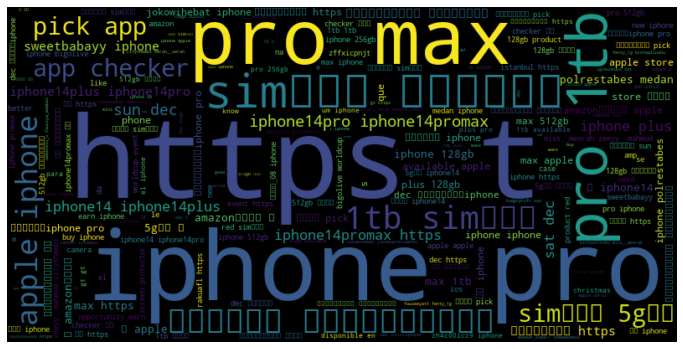

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')

## BERT

In [ ]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
classifier = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
iphone_tweets_post['rawContent'][963]

'楽天 モバイルの新規入会特典🎁 iphone 14 iphone13 クーポン一覧 キャンペーン エントリー ★ポイントを追加して お得に申し込もう😄6 https://t.co/gw3bvl05bc'

In [ ]:
senti_score_post=[0]*len(iphone_tweets_post)
for ind in range(0, len(iphone_tweets_post)):
  senti_score_post[ind] = classifier(iphone_tweets_post['rawContent'][ind])[0]['score']

In [ ]:
senti_score_post

[0.3964676260948181,
 0.6570945382118225,
 0.2777142822742462,
 0.2981702387332916,
 0.35511988401412964,
 0.3198632001876831,
 0.4219282269477844,
 0.5100969672203064,
 0.43108025193214417,
 0.47076845169067383,
 0.5053589940071106,
 0.6960006356239319,
 0.5313752293586731,
 0.26525792479515076,
 0.5762671232223511,
 0.2876751720905304,
 0.2597448229789734,
 0.29740607738494873,
 0.2740028202533722,
 0.6571410894393921,
 0.6550112366676331,
 0.6643669605255127,
 0.6525576710700989,
 0.4307078421115875,
 0.47147342562675476,
 0.5590453147888184,
 0.6627693176269531,
 0.5579240918159485,
 0.6602529883384705,
 0.47302958369255066,
 0.3956497013568878,
 0.2762305736541748,
 0.2390768975019455,
 0.3032017648220062,
 0.2513554096221924,
 0.2775402069091797,
 0.3224409818649292,
 0.7296806573867798,
 0.46576181054115295,
 0.4149380326271057,
 0.5388078093528748,
 0.3699854910373688,
 0.322994202375412,
 0.23199941217899323,
 0.5201089978218079,
 0.43259623646736145,
 0.25699326395988464,
 0.

In [ ]:
iphone_tweets_post['BERT sentimental score'] = senti_score_post

In [ ]:
iphone_tweets_post.head()

,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,...,hashtags,cashtags,card,score,negative,neutral,positive,compound,sentiment,BERT sentimental score
0,snscrape.modules.twitter.Tweet,https://twitter.com/leonardopaez/status/160172...,2022-12-10 23:59:42+00:00,@wok1n iphone 14+,@Wok1n Iphone 14+,1601728392277413888,"{'_type': 'snscrape.modules.twitter.User', 'us...",2,0,1,...,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral,0.396468
1,snscrape.modules.twitter.Tweet,https://twitter.com/EightKomo/status/160172837...,2022-12-10 23:59:37+00:00,twitter left thirty thots blocked... timeline ...,Twitter should have left these thirty thots bl...,1601728375243956224,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,...,NaN,NaN,NaN,"{'neg': 0.195, 'neu': 0.805, 'pos': 0.0, 'comp...",0.195,0.805,0.000,-0.5574,negative,0.657095
2,snscrape.modules.twitter.Tweet,https://twitter.com/AppleStore_KT/status/16017...,2022-12-10 23:58:53+00:00,★銀座★ 在庫復活_08:58 iphone 14 pro/pro max - apple ...,★銀座★ 在庫復活_08:58 iPhone 14 pro/pro max\n - Appl...,1601728189281492993,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,...,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral,0.277714
3,snscrape.modules.twitter.Tweet,https://twitter.com/perry_monk/status/16017281...,2022-12-10 23:58:52+00:00,@smartsheila think much better picture would'v...,@Smartsheila Just think how much better that p...,1601728184013434880,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,...,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...",0.000,0.707,0.293,0.4404,positive,0.298170
4,snscrape.modules.twitter.Tweet,https://twitter.com/akiatoji/status/1601728129...,2022-12-10 23:58:39+00:00,それだけでなくiosがアップデートされないとペアリングしてるwatchもairpods pr...,それだけでなくiOSがアップデートされないとペアリングしてるWatchもAirpods Pr...,1601728129478770688,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral,0.355120


In [ ]:
def polarity_score_BERT(compound):
    if compound > 0.45:
        return "positive"
    elif compound < 0.4:
        return "negative"
    elif compound < 0.55 and compound > 0.4:
        return "neutral"

In [ ]:
iphone_tweets_post['BERT sentiment'] = iphone_tweets_post['BERT sentimental score'].apply(lambda val: polarity_score_BERT(val))

In [ ]:
fig = px.histogram(iphone_tweets_post, x='BERT sentiment', color = 'BERT sentiment', color_discrete_map = color_code)
fig.show()